### MSc in CSTE, CIDA option's Advanced Python & Advanced Java Assignment

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d as plt3d
import numpy as np
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from tabulate import tabulate

class MultiLinearRegression:

    def __init__(self, filename, predColIndexes, targetColIndex, iterations, learningRate):
        # Read data from file:
        self.filename = filename

        # Load data, remove first row (columns names), remove nan values and normalize it:
        self.columnsNames = np.genfromtxt(self.filename, delimiter=',', dtype=str, max_rows=1)
        self.targetIndex = targetColIndex
        self.predIndexes = predColIndexes
        self.data = np.genfromtxt(self.filename, delimiter=',', skip_header=1)  # Skip first row, which is columns names
        self.data = self.data[~np.isnan(self.data).any(axis=1)]                 # Remove nan values
        self.data = preprocessing.scale(self.data)                              # Normalize data
        self.data = self.data[~(np.abs(self.data) > 3).any(axis=1)]             # Remove extreme values

        # Split data into features and target, and add a column of ones to features:
        self.Y = self.data[:, targetColIndex]
        self.data = self.data[:, predColIndexes]
        self.data = np.insert(self.data, 0, 1, axis=1)

        # Split data into train and test randomly:
        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(self.data, self.Y, test_size=0.2, random_state=23)

        # Number of features and observations:
        self.r = len(self.data[0])  # number of features
        self.n = len(self.data)  # number of observations

        # Initialize thetas, hypothesis, iterations and learning rate:
        self.thetas = np.zeros(self.r)  # initialize thetas
        self.hypothesis = np.zeros(self.n)  # initialize hypothesis
        self.iterations = iterations    # keep in memory iterations amount requested upon initialization
        self.learningRate = learningRate    # keep in memory learning rate requested upon initialization

        # Cost:
        self.cost = []

    # Plot train and test data in 3D in different colors and different plots:
    def plotTrainAndTestData(self):
        fig = plt.figure(figsize=(15, 10))
        fig.suptitle(self.filename+' : Train and Test Data')
        fig.subplots_adjust(top=1.10)
        ax = fig.add_subplot(1, 2, 1, projection='3d')
        ax.scatter3D(self.X_train[:, 1], self.X_train[:, 2], self.Y_train, c='red', label='Train Data (Proportion=0.8)', marker='.')
        ax.set_zlabel(self.columnsNames[self.targetIndex])
        ax.legend()

        ax = fig.add_subplot(1, 2, 2, projection='3d')
        ax.scatter3D(self.X_test[:, 1], self.X_test[:, 2], self.Y_test, c='blue', label='Test Data (Proportion=0.2)', marker='.')
        ax.set_zlabel(self.columnsNames[self.targetIndex])
        ax.legend()

        plt.show()

    # Plot each predictor against the target in different colors:
    def plotPredictorsVsTarget(self):
        fig, axs = plt.subplots(1, self.r-1, figsize=(15, 5))
        colors = ['red', 'green', 'blue', 'orange', 'black', 'orange', 'purple', 'brown', 'pink', 'gray']
        # In order to skip the first column (which is a column of ones), we must tweak a bit our for loop:
        for i in range(1, self.r):
            axs[i-1].scatter(self.data[:, i], self.Y, c=colors[i-1], marker='.')
            axs[i-1].set_xlabel(self.columnsNames[i])
            axs[i-1].set_ylabel(self.columnsNames[-1])
            axs[i-1].set_title('('+self.columnsNames[self.targetIndex]+') vs ('+self.columnsNames[self.predIndexes[i-1]]+')')
        fig.suptitle(self.filename+' : Target ('+self.columnsNames[self.targetIndex]+') vs Multiples Predictors')
        fig.subplots_adjust(top=0.85)
        plt.show()

    # Plot y test vs y predicted:
    def plotYTestVsYPredicted(self):
        Y_pred = np.dot(self.X_test, self.thetas)
        Y_test = self.Y_test
        Y_test, Y_pred = zip(*sorted(zip(Y_test, Y_pred)))
        observations = np.arange(1, len(Y_pred)+1)
        plt.scatter(observations, Y_pred, label='Y Predicted', color='blue', marker='.')
        plt.scatter(observations, Y_test, label='Y Test', color='red', marker='.')
        plt.xlabel('Observations')
        plt.ylabel(self.columnsNames[self.targetIndex])
        plt.legend()
        plt.title(self.filename+' : Y Test vs Y Predicted')
        plt.show()

    # Gradient descent:
    def gradientDescent(self):
        cost = []
        for i in range(self.iterations):
            self.hypothesis = np.dot(self.X_train, self.thetas)
            self.thetas -= self.learningRate * (2 / self.n) * np.dot(self.X_train.T, self.hypothesis - self.Y_train)
            cost.append(1 / self.n * np.sum((self.hypothesis - self.Y_train) ** 2))
        self.cost = cost
        return cost

    # Gradient descent while thetas successive differences are greater than 0.0001:
    def gradientDescentUntilConvergence(self):
        cost = []
        thetas = np.ones(self.r)   # used to compare thetas with their previous values
        while np.sum(np.abs(thetas - self.thetas)) > 0.0001:
            thetas = np.copy(self.thetas)
            self.hypothesis = np.dot(self.X_train, self.thetas)
            self.thetas -= self.learningRate * (2 / self.n) * np.dot(self.X_train.T, self.hypothesis - self.Y_train)
            cost.append(1 / self.n * np.sum((self.hypothesis - self.Y_train) ** 2))
        self.cost = cost
        return cost

    # Plot cost:
    def plotCost(self):
        plt.plot(self.cost, label='cost evolution, itr=' + str(self.iterations)+', eta='+str(self.learningRate))
        plt.title('\''+self.filename+'\'')
        plt.xlabel('Iterations')
        plt.ylabel('Cost')
        plt.legend()
        plt.show()

    # Compute R2:
    def computeR2(self):
        return 1 - np.sum(np.square(self.Y_test - np.dot(self.X_test, self.thetas))) / np.sum(np.square(self.Y_test - np.mean(self.Y_test)))

    # Print R2:
    def printR2(self):
        print('Computed R2 for the ' + self.filename + ' data, in percentage: ', str(np.round(self.computeR2()*100, 2)), ' %')

    # Compute SKLearn R2 using LinearRegression:
    def computeSKLearnR2(self):
        lr = LinearRegression()
        lr.fit(self.X_train, self.Y_train)
        lr.predict(self.X_test)
        return lr.score(self.X_test, self.Y_test)

    # Print SKLearn gradient descent R2:
    def printSKLearnR2(self):
        print('SKLearn R2 for the ' + self.filename + ' data, in percentage: ', str(np.round(self.computeSKLearnR2()*100, 2)), ' %')

In [18]:
# Plot multiples cost in one plot with different learning rates and different colors:
def plotMultipleCosts(filename, predColIndexes, targetColIndex, learningRates, iterations):
    colors = ['red', 'blue', 'orange', 'grey', 'purple']
    for i in range(len(learningRates)):
        mlr = MultiLinearRegression(filename, predColIndexes, targetColIndex, iterations, learningRates[i])
        mlr.gradientDescent()
        plt.plot(mlr.cost, color=colors[i], label='eta='+str(learningRates[i]))
    plt.title('\''+filename+'\'')
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.legend()
    plt.show()

# Plot multiple plots in one figure:
def plotMultiple(filename, predColIndexes, targetColIndex, iterations, learningRates):
    fig, axs = plt.subplots(4, 4)
    fig.suptitle(filename+' : Cost for various iterations and learning rates values.')
    for i in range(len(learningRates)):
        for j in range(len(iterations)):
            mlr = MultiLinearRegression(filename, predColIndexes, targetColIndex, iterations[j], learningRates[i])
            mlr.gradientDescent()
            axs[i, j].plot(mlr.cost, label='itr=' + str(iterations[j]) + ', eta=' + str(learningRates[i]))
            axs[i, j].set_xlabel('Iterations')
            axs[i, j].set_ylabel('Cost')
            axs[i, j].text(0.35, 0.25, 'R2: ' + str(round(mlr.computeR2(), 2)), horizontalalignment='center',
                           verticalalignment='center', transform=axs[i, j].transAxes)
            axs[i, j].legend()
    fig.set_size_inches(16.5, 10.5)
    fig.subplots_adjust(top=0.93)
    plt.show()

# 3D plot of R2 for various iterations and learning rates values with contour plot:
def plot3D(filename, predColIndexes, targetColIndex, iterations, learningRates):
    fig = plt.figure()
    ax = plt3d.Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Learning rate')
    ax.set_zlabel('R2')
    ax.set_title(filename)
    X, Y = np.meshgrid(iterations, learningRates)
    Z = np.zeros((len(learningRates), len(iterations)))
    for i in range(len(learningRates)):
        for j in range(len(iterations)):
            mlr = MultiLinearRegression(filename, predColIndexes, targetColIndex, iterations[j], learningRates[i])
            mlr.gradientDescent()
            Z[i, j] = mlr.computeR2()
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='cool', edgecolor='black')
    ax.view_init(30, 230)
    ax.text2D(0.22, 0.95, 'Computation of R**2 for various iterations and eta values', transform=ax.transAxes)
    plt.show()


# Table of R2 for various iterations and learning rates values using tabulate:
def tableOfR2(filename, predColIndexes, targetColIndex, iterations, learningRates):
    table = []
    for i in range(len(learningRates)):
        row = [learningRates[i]]
        for j in range(len(iterations)):
            mlr = MultiLinearRegression(filename, predColIndexes, targetColIndex, iterations[j], learningRates[i])
            mlr.gradientDescent()
            row.append(round(mlr.computeR2(), 4))
        table.append(row)
    print(filename+' : Table of R2 for various iterations and learning rates values:')
    print(tabulate(table, headers=['LR \ ITR'] + iterations, tablefmt='fancy_grid'))

# Print max R2 for various iterations and learning rates values, at .001 % precision:
def printMaxR2(filename, predColIndexes, targetColIndex, iterations, learningRates):
    maxR2 = 0
    maxR2Index = [0, 0]
    for i in range(len(learningRates)):
        for j in range(len(iterations)):
            mlr = MultiLinearRegression(filename, predColIndexes, targetColIndex, iterations[j], learningRates[i])
            mlr.gradientDescent()
            if np.abs(mlr.computeR2() - maxR2) > 0.00001:
                maxR2 = mlr.computeR2()
                maxR2Index = [i, j]
    print(filename+' : Max R2: ', np.round(maxR2*100,2), ' % (for itr=', iterations[maxR2Index[1]], ', and eta=', learningRates[maxR2Index[0]], ')')


# Table of iterations needed for convergence for various learning rates values using tabulate:
def tableOfIterations(filename, predColIndexes, targetColIndex, learningRates):
    table = []
    for i in range(len(learningRates)):
        mlr = MultiLinearRegression(filename, predColIndexes, targetColIndex, 100000, learningRates[i]) # Iterations parameter is not important here
        mlr.gradientDescentUntilConvergence()
        table.append([learningRates[i], len(mlr.cost)])
    print(filename+' : Table of iterations needed for convergence, for various learning rates values:')
    print(tabulate(table, headers=['Learning rate', 'Iterations'], tablefmt='fancy_grid'))

# Table of difference between computed R2 and SKlearn R2, for various iterations and learning rates values using tabulate:
def tableOfR2Diff(filename, predColIndexes, targetColIndex, iterations, learningRates):
    table = []
    for i in range(len(learningRates)):
        row = [learningRates[i]]
        for j in range(len(iterations)):
            mlr = MultiLinearRegression(filename, predColIndexes, targetColIndex, iterations[j], learningRates[i])
            mlr.gradientDescent()
            row.append(str(abs(round((mlr.computeR2() - mlr.computeSKLearnR2())*100, 2))) + ' %')
        table.append(row)
    print(filename+' : Table of difference between computed R2 and SKlearn R2, for various iterations and learning rates values:')
    print(tabulate(table, headers=['LR \ ITR'] + iterations, tablefmt='fancy_grid'))

In [19]:
# Files and their predictor and target columns indexes:
files = [['dataEnergy.csv', [0, 1, 2, 3], 4], ['dataLoans.csv', [1, 4], 0]]

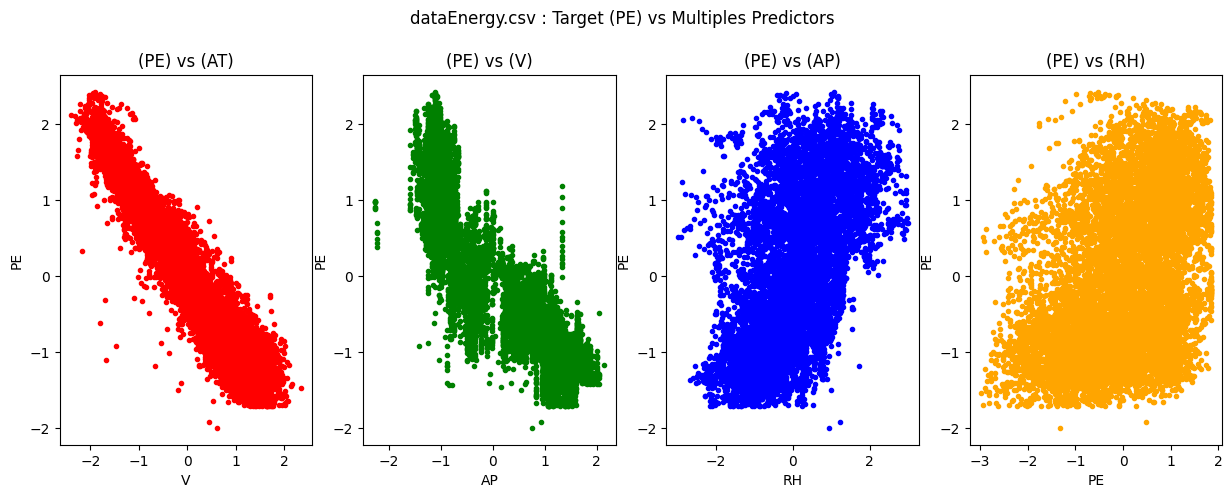

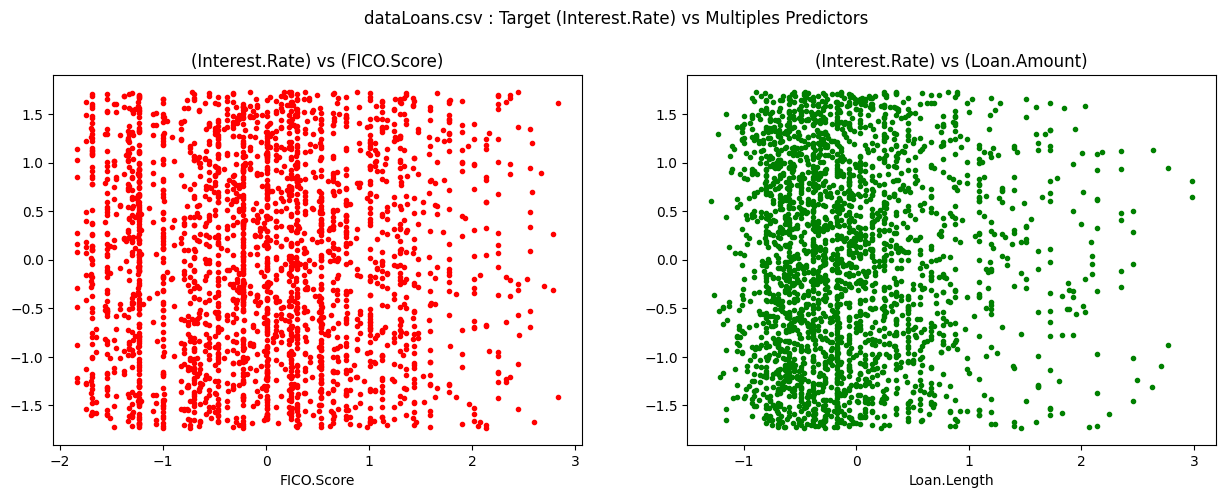

In [20]:
for file in files :
    mlr = MultiLinearRegression(file[0], file[1], file[2], 1000, 0.01)
    mlr.plotPredictorsVsTarget()

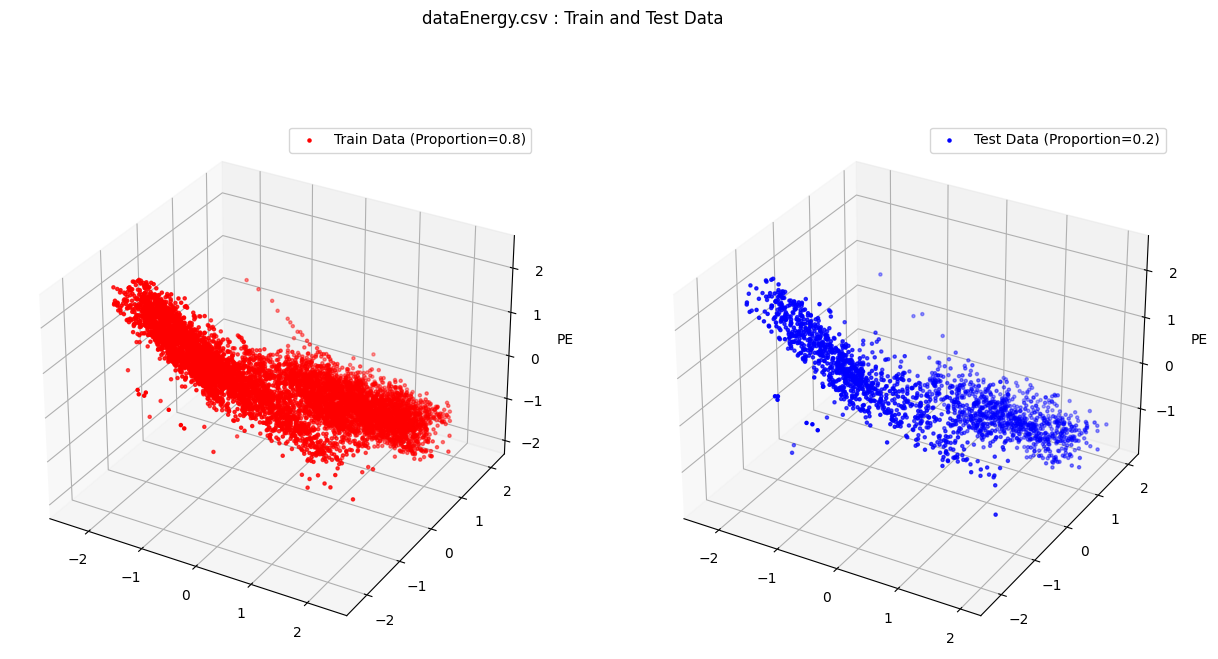

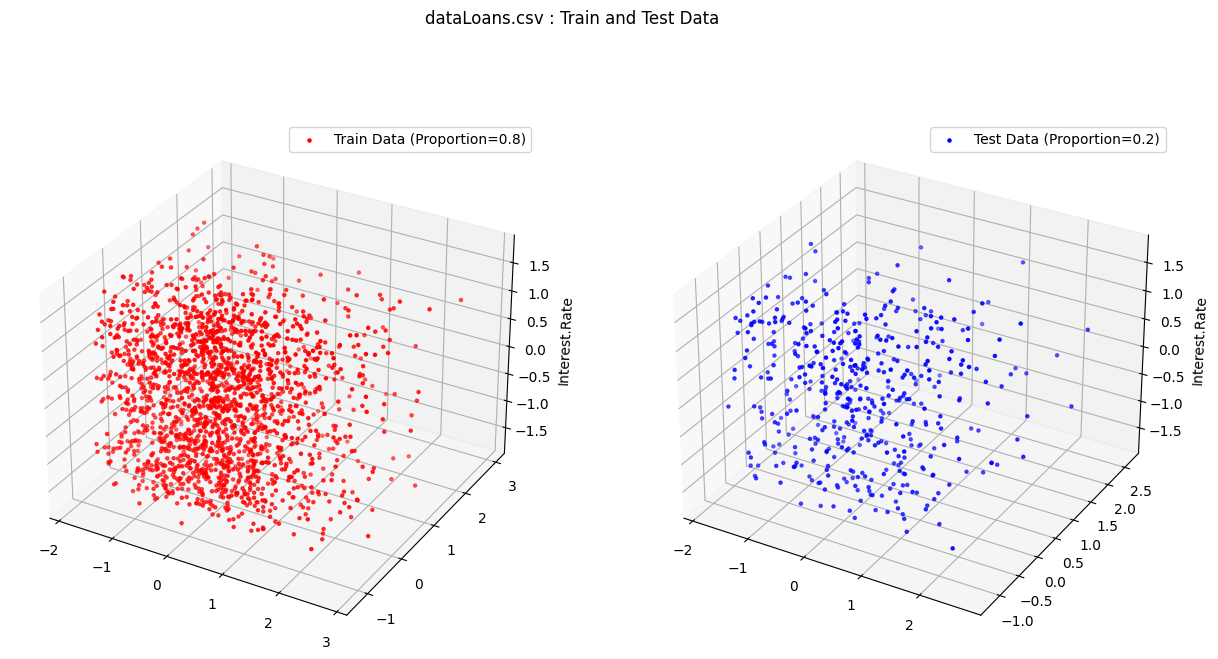

In [15]:
for file in files:
    # Plot train and test data in 3D in different colors and different plots:
    mlr = MultiLinearRegression(file[0], file[1], file[2], 1000, 0.01)
    mlr.plotTrainAndTestData()

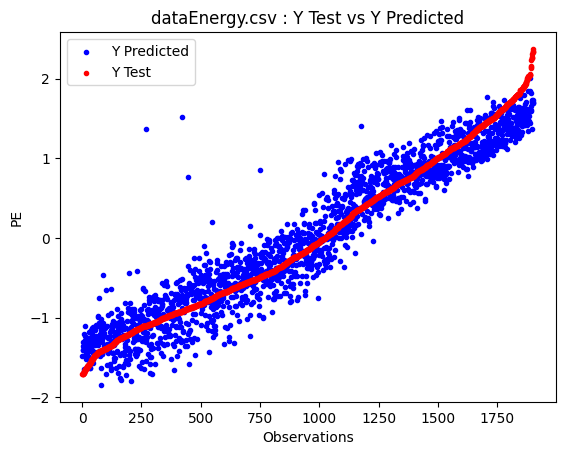

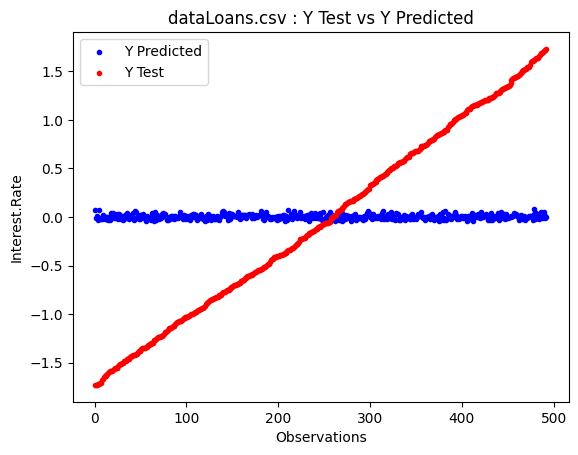

In [16]:
for file in files :
    # Plot Y pred vs Y target for various iterations and learning rates values:
    mlr = MultiLinearRegression(file[0], file[1], file[2], 1000, 0.01)
    mlr.gradientDescent()
    mlr.plotYTestVsYPredicted()

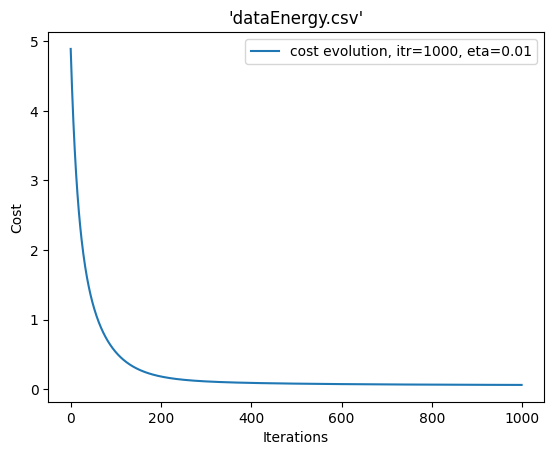

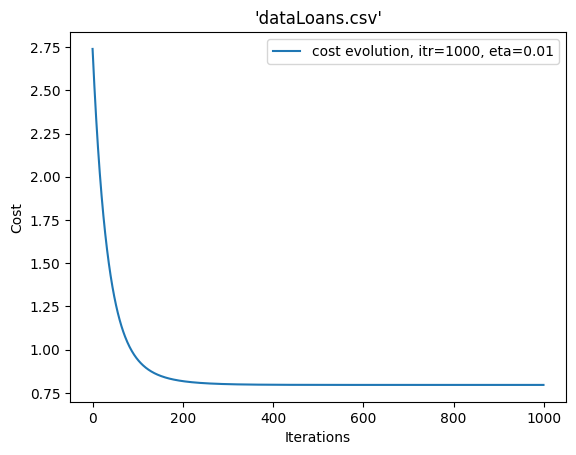

In [17]:
for file in files:
    # Create MultiLinearRegression object by referencing the data, predictor and target columns; as well as the number of iterations and learning rate:
    mlr = MultiLinearRegression(file[0], file[1], file[2], 1000, 0.01)
    # Compute gradient descent with previously given number of iterations and learning rate:
    mlr.gradientDescent()
    # Plot the cost function:
    mlr.plotCost()

In [21]:
for file in files:
    mlr = MultiLinearRegression(file[0], file[1], file[2], 1000, 0.01)
    mlr.gradientDescent()
    # Print its R2:
    mlr.printR2()

Computed R2 for the dataEnergy.csv data, in percentage:  92.49  %
Computed R2 for the dataLoans.csv data, in percentage:  0.1  %


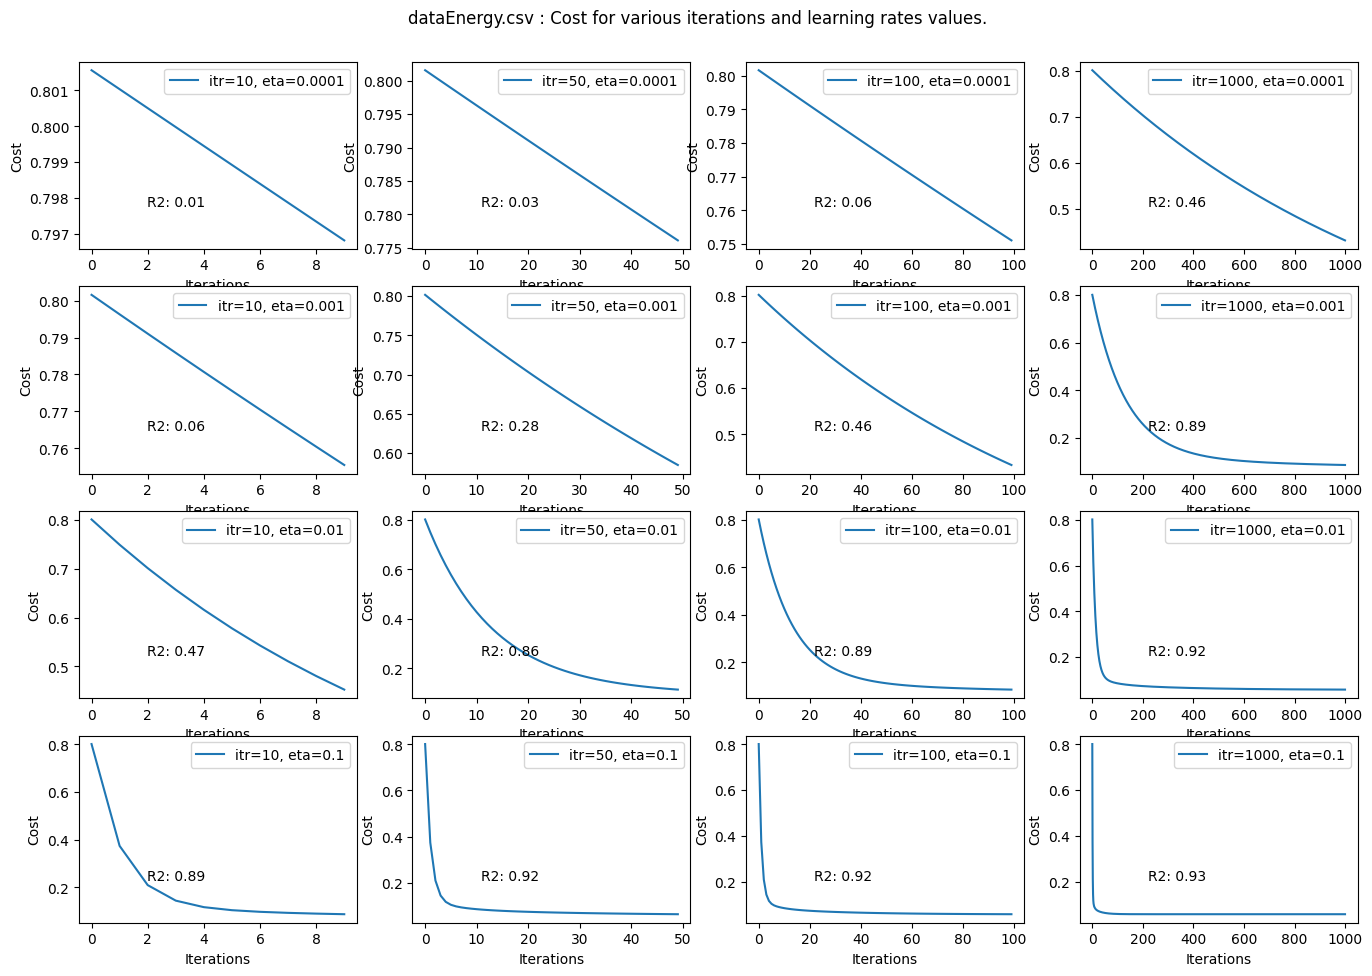

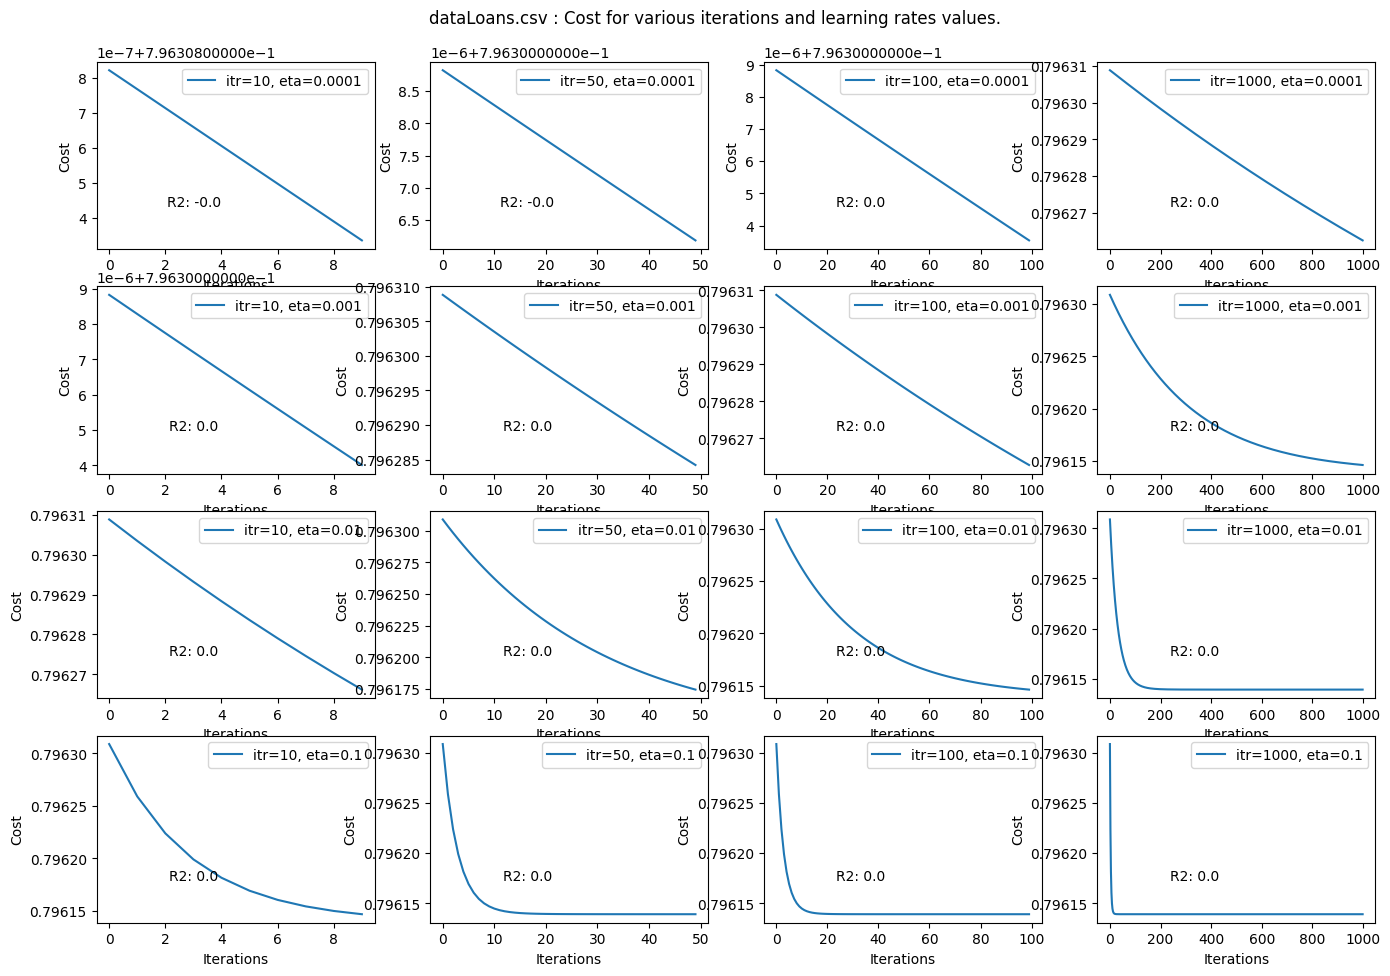

In [22]:
for file in files:
    mlr = MultiLinearRegression(file[0], file[1], file[2], 1000, 0.01)
    mlr.gradientDescent()
    # Plot cost for various iterations and learning rates values:
    plotMultiple(file[0], file[1], file[2], [10, 50, 100, 1000], [0.0001, 0.001, 0.01, 0.1])

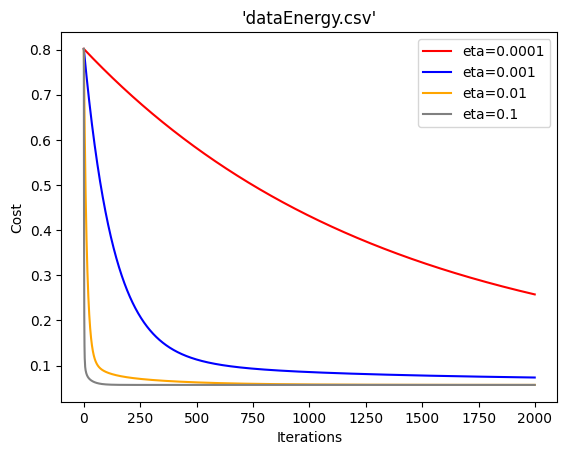

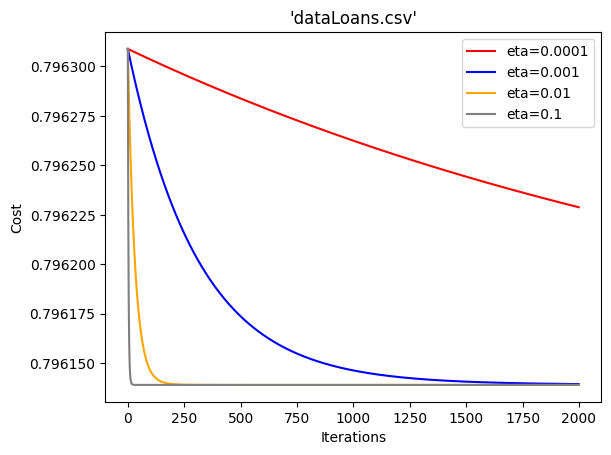

In [30]:
for file in files:
    plotMultipleCosts(file[0], file[1], file[2], [0.0001, 0.001, 0.01, 0.1], 2000)

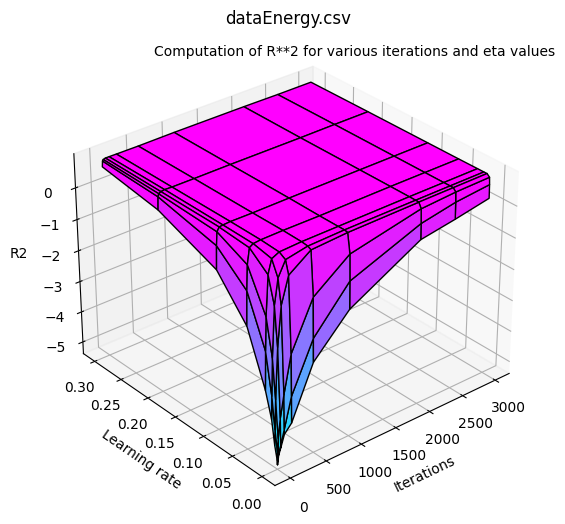

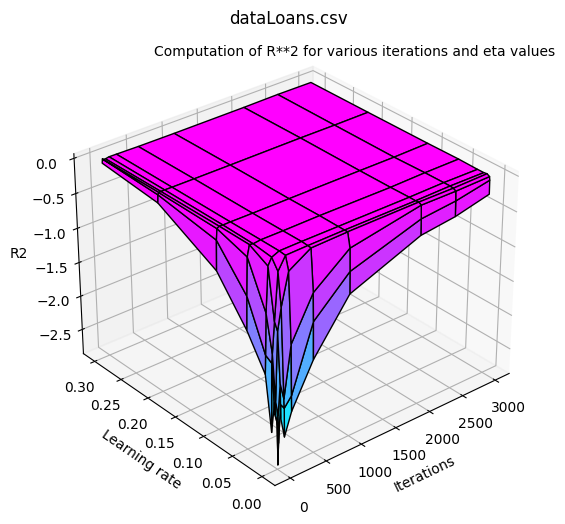

In [21]:
for file in files:
    mlr = MultiLinearRegression(file[0], file[1], file[2], 1000, 0.01)
    mlr.gradientDescent()
    # Plot R2 for various iterations and learning rates values:
    plot3D(file[0], file[1], file[2], [5, 10, 20, 50, 100, 200, 500, 1000, 2000, 2500, 3000],
           [0.0003, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3])

In [23]:
# Compute max R2 for various iterations and learning rates values, at .01 % precision:
for file in files:
    printMaxR2(file[0], file[1], file[2], [5, 10, 20, 50, 100, 200, 500, 1000, 2000, 2500, 3000], [0.0003, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3])

dataEnergy.csv : Max R2:  92.59  % (for itr= 200 , and eta= 0.3 )
dataLoans.csv : Max R2:  0.1  % (for itr= 20 , and eta= 0.3 )


In [23]:
# Table of R2 for various iterations and learning rates values:
for file in files:
    tableOfR2(file[0], file[1], file[2], [5, 10, 20, 50, 100, 200, 500, 1000, 2000, 2500], [0.0003, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3])
    print('\n')

dataEnergy.csv : Table of R2 for various iterations and learning rates values:
╒════════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤════════╕
│   LR \ ITR │       5 │      10 │      20 │      50 │     100 │     200 │     500 │    1000 │    2000 │   2500 │
╞════════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪════════╡
│     0.0003 │ -5.2298 │ -5.1428 │ -5.3512 │ -5.0241 │ -4.4099 │ -3.9363 │ -2.4919 │ -1.4545 │ -0.2017 │ 0.0286 │
├────────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────┤
│     0.0005 │ -5.2692 │ -5.0133 │ -4.8711 │ -4.5666 │ -3.8477 │ -3.2086 │ -1.6156 │ -0.5911 │  0.3865 │ 0.513  │
├────────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────┤
│     0.001  │ -5.2515 │ -4.9899 │ -4.849  │ -4.1075 │ -3.3161 │ -2.1297 │ -0.5463 │  0.3655 │  0.7683 │ 0.8288 │
├────────

In [24]:
# Table of iterations needed for convergence for various learning rates values:
for file in files:
    tableOfIterations(file[0], file[1], file[2], [0.0003, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3])
    print('\n')

dataEnergy.csv : Table of iterations needed for convergence, for various learning rates values:
╒═════════════════╤══════════════╕
│   Learning rate │   Iterations │
╞═════════════════╪══════════════╡
│          0.0003 │        10146 │
├─────────────────┼──────────────┤
│          0.0005 │         8542 │
├─────────────────┼──────────────┤
│          0.001  │         7642 │
├─────────────────┼──────────────┤
│          0.005  │         3427 │
├─────────────────┼──────────────┤
│          0.01   │         2124 │
├─────────────────┼──────────────┤
│          0.02   │         1266 │
├─────────────────┼──────────────┤
│          0.05   │          624 │
├─────────────────┼──────────────┤
│          0.1    │          352 │
├─────────────────┼──────────────┤
│          0.2    │          197 │
├─────────────────┼──────────────┤
│          0.3    │          138 │
╘═════════════════╧══════════════╛


dataLoans.csv : Table of iterations needed for convergence, for various learning rates values:
╒═

In [24]:
# Compute own R2 and SKLearn R2, and print both of them:
for file in files:
    mlr = MultiLinearRegression(file[0], file[1], file[2], 1000, 0.01)
    mlr.gradientDescent()
    mlr.printR2()
    mlr.printSKLearnR2()

Computed R2 for the dataEnergy.csv data, in percentage:  92.49  %
SKLearn R2 for the dataEnergy.csv data, in percentage:  92.59  %
Computed R2 for the dataLoans.csv data, in percentage:  0.1  %
SKLearn R2 for the dataLoans.csv data, in percentage:  0.1  %


Since it seems there's a difference between the computed R2 and the SKLearn R2 for 1000 iterations and a learning rate of 0.01, it may be interesting to table difference between both R2 for various iterations and learning rates values.

In [26]:
# Table of difference between computed R2 and R2 using SKLearn, for various iterations and learning rates values:
for file in files:
    tableOfR2Diff(file[0], file[1], file[2], [5, 10, 20, 50, 100, 200, 500, 1000, 2000],
                  [0.0003, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3])
    print('\n')

dataEnergy.csv : Table of difference between computed R2 and SKlearn R2, for various iterations and learning rates values:
╒════════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╕
│   LR \ ITR │ 5        │ 10       │ 20       │ 50       │ 100      │ 200      │ 500      │ 1000     │ 2000     │
╞════════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
│     0.0003 │ 587.53 % │ 644.95 % │ 607.21 % │ 564.38 % │ 549.33 % │ 494.98 % │ 347.06 % │ 222.88 % │ 128.04 % │
├────────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│     0.0005 │ 591.92 % │ 590.83 % │ 576.4 %  │ 561.57 % │ 492.07 % │ 411.42 % │ 259.52 % │ 144.45 % │ 57.31 %  │
├────────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│     0.001  │ 597.58 % │ 580.16 % │ 546.58 % │ 486.86 % │ 410.56 % │ 301.27 % 

With our implementation of the gradient descend, it seems that the difference between our R2 and SKLearn's R2 is very small, almost negligable, making our implementation successful.

In [28]:
# Compute own R2 and SKLearn R2, and print both of them, with interesting values:
for file in files:
    mlr = MultiLinearRegression(file[0], file[1], file[2], 500, 0.1)
    mlr.gradientDescent()
    mlr.printR2()
    mlr.printSKLearnR2()

Computed R2 for the dataEnergy.csv data, in percentage:  92.59  %
SKLearn R2 for the dataEnergy.csv data, in percentage:  92.59  %
Computed R2 for the dataLoans.csv data, in percentage:  0.1  %
SKLearn R2 for the dataLoans.csv data, in percentage:  0.1  %


### CQFD